# 필요한 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import re
import matplotlib.pyplot as plt

# 데이터 불러오기

In [2]:
file_path = os.getenv('HOME') + '/aiffel/songys_chatbot/ChatbotData.csv'
cd = pd.read_csv(file_path)

In [3]:
cd

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


# 트랜스포머에 필요한 함수 정의

## 포지셔널 인코딩

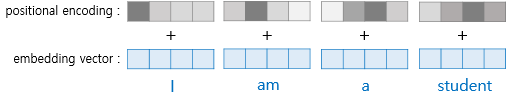

트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받기 때문에

문장에 있는 모든 단어를 한꺼번에 문장 단위로 입력받는 트랜스포머는 자칫 'I ate lunch'와 'lunch ate I'를 구분할 수 없을지도 모름

그래서 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려 주기 위해, 

단어의 임베딩 벡터에다가 위치 정보를 가진 벡터(Positional Encoding) 값을 더해서 모델에 입력

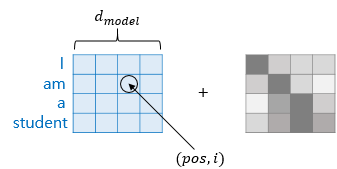

$d_{model}$은 임베딩 벡터의 차원을 의미하고 있고, $pos$는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, 

$i$는 임베딩 벡터 내의 차원의 인덱스를 의미

이렇게 임베딩 행렬과 포지셔널 행렬이라는 두 행렬을 더함으로써 각 단어 벡터에 위치 정보를 더해주게 되는 것

In [4]:
class PositionalEncoding(tf.keras.layers.Layer):
    
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
        
    def positional_encoding(self, position, d_model):
        #각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        #배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        #배열의 홀수 인덱스에는 cos 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        #sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## 스케일드 닷 프로덕트 어텐션 함수
-  **내적(dot product)**을 통해 단어 벡터 간 **유사도**를 구한 후에, **특정 값을 분모로 나눠주는 방식**으로 Q와 K의 유사도를 구함

$Attention(Q,K,V)=softmax(QK^T / √d_k)V$


1. Q, K, V는 단어 벡터를 행으로 하는 문장 행렬이다.


2. 벡터의 내적(dot product)은 벡터의 유사도를 의미한다.


3. 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling)을 위함이다.

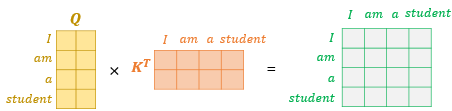

예를 들어 'am' 행과 'student' 열의 값은 

Q 행렬에 있던 'am' 벡터와 

K 행렬에 있던 'student 벡터'의 내적값을 의미

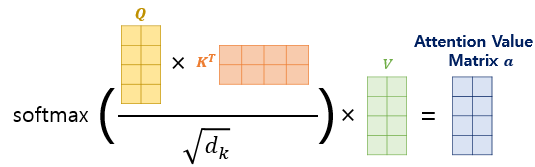

이 유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값($(root(d_k)$)으로 나눠주고, 

유사도를 0과 1사이의 값으로 Normalize해주기 위해서 소프트맥스 함수를 사용

여기까지가 Q와 K의 유사도를 구하는 과정

여기에 문장 행렬 V와 곱하면 어텐션 값(Attention Value) 를 얻음

In [5]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


## 병렬로 어텐션 수행하기

### 멀티-헤드 어텐션

In [6]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 생성
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용
        outputs = self.dense(concat_attention)

        return outputs

## 마스킹

### 패딩 마스킹
- 패딩 토큰(Padding token)을 이용한 방법

- 사실 이렇게 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외

- 패딩 마스킹은 이를 위해 숫자 0인 위치를 체크

- 패딩(Padding)

패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 

정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법

In [7]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

#이 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴

In [8]:
#예시
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

#숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


### 룩 어헤드 마스킹(다음 단어 가리기)
- 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹

RNN은 step이라는 개념이 존재해서 각 **step마다 단어가 순서대로** 입력으로 들어가는 구조인 반면 

트랜스포머의 경우에는 문장 행렬을 만들어 **한 번에 행렬 형태**로 입력으로 들어감

그리고 이 특징 때문에 추가적인 마스킹(Masking) 을 필요

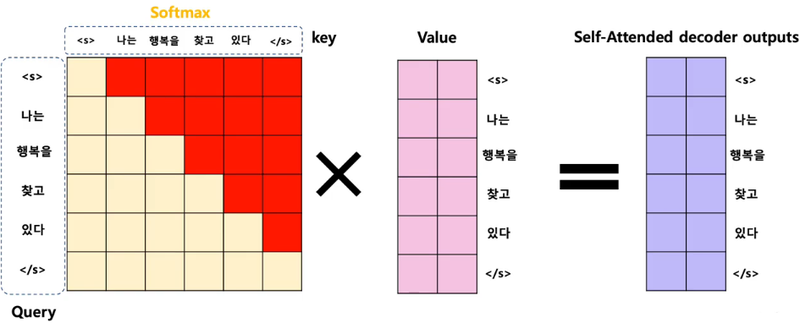

행을 Query, 열을 Key로 표현된 행렬

빨간색으로 색칠된 부분은 마스킹을 표현

실제 어텐션 연산에서 가리는 역할을 하여 어텐션 연산 시에 현재 단어를 기준으로 이전 단어들하고만 유사도를 구할 수 있음

예를 들어 Query 단어가 '찾고'라고 한다면, 

이 '찾고'라는 행에는 <s, 나는, 행복을, 찾고> 까지의 열만 보이고 
    
그 뒤 열은 아예 빨간색으로 칠해져 있음. 
    
즉, 유사도를 구할 수 없도록 해놓음

In [9]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]  #행의 길이
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [10]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))
# 대각선의 형태로 숫자 1이 채워지는 것을 볼 수 있습니다. 
# 이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야 함

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [11]:
#숫자 0인 단어가 있을 경우
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 인코더
- 셀프 어텐션 + 피드 포워드 신경망
- 셀프 어텐션은 멀티 헤드 어텐션으로 이루어져 있음

In [12]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
          d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 인코더 층을 쌓아 인코더 만들기
- 구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 

- 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성

- 인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용

In [13]:
def encoder(vocab_size,
           num_layers,
           units,
           d_model,
           num_heads,
           dropout,
           name='encoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    
    #패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    #임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    #포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 쌓아올린 인코더의 층
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='encoder_layer_{}'.format(i),
        )([outputs, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

- Layer Normalization

각 input의 feature들에 대한 평균과 분산을 구해서 batch에 있는 각 input을 정규화


cf) Batch Nomalization

: 각 feature의 평균과 분산을 구해서 batch에 있는 각 feature를 정규화

참고 링크 : https://yonghyuc.wordpress.com/2020/03/04/batch-norm-vs-layer-norm/

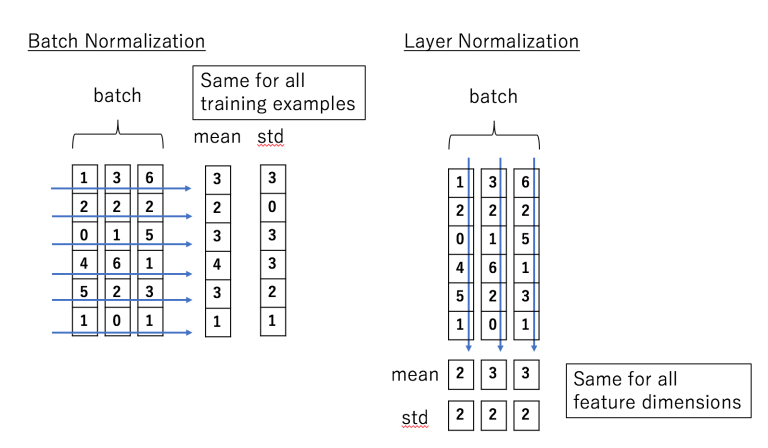

## 디코더
- 셀프 어텐션 + 인코더-디코더 어텐션 + 피드 포워드 신경망
- 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행

- 인코더-디코더 어텐션

셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징

이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정

In [14]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
          d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
    
    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
          d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
    
    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
          inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)

### 디코더 층을 쌓아 디코더 만들기
- 구현한 디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 
- 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성

In [15]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
            )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
          inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)

# 데이터 전처리

정규 표현식(Regular Expression) 을 사용하여 구두점(punctuation) 을 제거하여

단어를 토크나이징(tokenizing) 하는 일에 방해가 되지 않도록 정제



## 데이터 전처리 함수

In [16]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    
    #단어와 구두점(punctuation) 사이의 거리를 만듦
    #예를 들어서 'I am a student' => 'I am a student .' 와 같이 sentence와 온점 사이에 거리를 만듦
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # (한글, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [17]:
cd

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


데이터의 총 개수가 10,000여개이므로 크지 않은 데이터이기 때문에 전체 데이터를 사용한다.

### 전처리 함수를 적용한 후 리스트 형식으로 저장

In [18]:
cd_questions = []
for i in cd['Q']:
    a = preprocess_sentence(i)
    cd_questions.append(a)

In [19]:
cd_answers = []
for i in cd['A']:
    a = preprocess_sentence(i)
    cd_answers.append(a)

In [20]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장
questions, answers = cd_questions, cd_answers
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


- 전처리가 잘 적용되었는 지 확인

In [21]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## 병렬 데이터 전처리

1. TensorFlow Datasets **SubwordTextEncoder**를 토크나이저로 사용.
 
    단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 **정수로 인코딩**


2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 **START_TOKEN** 및 **END_TOKEN**을 추가


3. 최대 길이 **MAX_LENGTH**인 40을 넘는 문장들은 필터링


4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 **패딩**

### 단어장 만들기
- 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용

In [22]:
#Tokenizer 생성

import tensorflow_datasets as tfds
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [23]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size+1]

In [24]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

#각각 8,127과 8,128이라는 점에서 현재 단어장의 크기가 8,127(0번부터 8,126번)이라는 의미

START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


In [25]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8129


### 각 단어를 고유한 정수로 인코딩, 패딩

In [26]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 25번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 25번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 25번째 질문 샘플: [5742, 612, 2481, 4148]
정수 인코딩 후의 25번째 답변 샘플: [2352, 7481, 7, 6245, 97, 1]


### 질문과 답변 셋에 대해서 전부 정수 인코딩을 수행
- 문장의 최대 길이를 정하고, 해당 길이로 패딩

- 질문, 답변 문장 최대길이 구하기

In [27]:
token_q = []
for i in questions:
    a = tokenizer.encode(i)
    token_q.append(a)

In [28]:
token_a = []
for i in answers:
    a = tokenizer.encode(i)
    token_a.append(a)

In [29]:
def max_len(token_list):
    m = []
    for i in range(1, len(token_list)):
        if len(token_list[i]) > len(token_list[i-1]):
            m.append(len(token_list[i]))
        else:
            continue
    return max(m)

In [30]:
print('질문 최대 길이 : ', max_len(token_q))
print('답변 최대 길이 : ', max_len(token_a))

질문 최대 길이 :  21
답변 최대 길이 :  29


- 질문, 답변 길이 분포 구하기

In [31]:
token_q_len = []
for i in range(len(token_q)-1):
    token_q_len.append(len(token_q[i]))

In [32]:
token_a_len = []
for i in range(len(token_a) -1):
    token_a_len.append(len(token_a[i]))

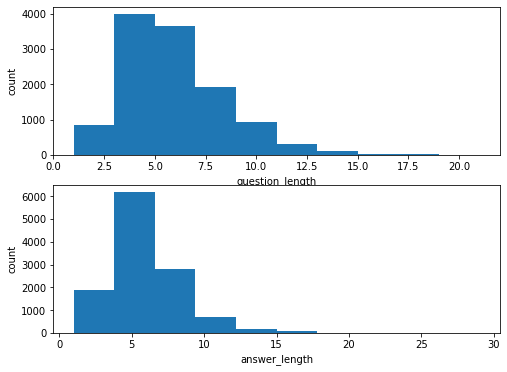

In [33]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.hist(token_q_len)
plt.xlabel('question_length')
plt.ylabel('count')

plt.subplot(2, 1, 2)
plt.hist(token_a_len)
plt.xlabel('answer_length')
plt.ylabel('count');

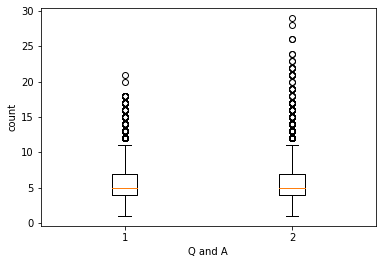

In [34]:
fig, ax = plt.subplots()
box = ax.boxplot([token_q_len, token_a_len])

ax.set_xlabel('Q and A')
ax.set_ylabel('count')

plt.show()

In [35]:
q_q3 = np.percentile(token_q_len, [75], interpolation='midpoint')
q_q1 = np.percentile(token_q_len, [25], interpolation='midpoint')
q_iqr = q_q3 - q_q1
whisker_q = q_q3 + (q_iqr*1.5)
whisker_q

array([11.5])

In [36]:
a_q3 = np.percentile(token_a_len, [75], interpolation='midpoint')
a_q1 = np.percentile(token_a_len, [25], interpolation='midpoint')
a_iqr = a_q3 - a_q1
whisker_a = a_q3 + (a_iqr*1.5)
whisker_a

array([11.5])

질문과 답변 각각의 문장 길이의 이상치 기준(Q3 + 1.5* IQR)을 반영하여

질문, 답변의 최대 길이는 각각 12(11.5 반올림)로 설정하였다.

In [37]:
MAX_LENGTH = 12

### 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩

In [38]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대 길이 12이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            
    # 최대 길이 12로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [39]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 10752
필터링 후의 답변 샘플 개수: 10752


샘플의 개수는 11,823에서 10,752로 줄어들었다.

# 교사 강요(Teacher Forcing) 사용하기
- **테스트 과정**에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법
- **훈련할 때** 교사 강요를 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, 
- t 시점의 레이블. 즉, **실제 알고있는 정답을 t+1 시점의 입력**으로 사용

질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 **파이프라인**을 구성

이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용

In [40]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 이에 따라 outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 모델 정의 및 학습

## 트랜스포머 함수 정의

In [41]:
def transformer(vocab_size,
               num_layers,
               units,
               d_model,
               num_heads,
               dropout,
               name='transformer'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    
    #인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    
    #디코더에서 미래의 토큰을 마스크하기 위해 사용
    #내부적으로 패딩 마스크도 포함
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape = (1, None, None),
        name = 'look_ahead_mask')(dec_inputs)
    
    #두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    #디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name = 'dec_padding_mask')(inputs)
    
    #인코더
    enc_outputs = encoder(
        vocab_size = vocab_size,
        num_layers = num_layers,
        units = units,
        d_model = d_model,
        num_heads = num_heads,
        dropout = dropout,
    )(inputs=[inputs, enc_padding_mask])
    
    #디코더
    dec_outputs = decoder(
        vocab_size = vocab_size,
        num_layers = num_layers,
        units = units,
        d_model = d_model,
        num_heads = num_heads,
        dropout = dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    #완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name='outputs')(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 모델 생성

In [45]:
tf.keras.backend.clear_session()

#하이퍼파라미터
NUM_LAYERS = 2  #인코더와 디코더의 층의 개수
D_MODEL = 512   #인코더와 디코더 내부의 입/출력의 고정 차원
NUM_HEADS = 8   #멀티 헤드 어텐션에서의 헤드 수
UNITS = 512   #피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1   #드롭아웃의 비율

model = transformer(
    vocab_size = VOCAB_SIZE,
    num_layers = NUM_LAYERS,
    units = UNITS,
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    dropout = DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    7318016     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 손실 함수

In [46]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

### SaprseCategoricalCrossentropy - from_logits
설명 링크 : https://hwiyong.tistory.com/335


## 커스텀된 학습률 스케쥴링
- 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법


### 커스텀 학습률 스케줄러를 통한 아담 옵티마이저

In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 커스텀 학습률 스케쥴링 시각화

Text(0.5, 0, 'Train Step')

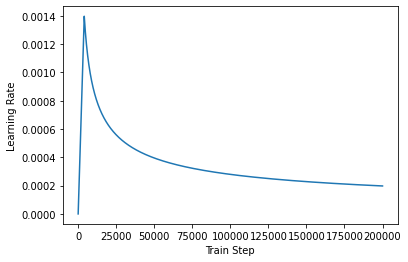

In [48]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#step_num^−0.5에 비례하는 부분과 step_num에 비례하는 부분 중 작은 쪽을 택하도록 되어 있음
#학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인

## 모델 컴파일

In [49]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## 훈련

In [50]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
168/168 [==============================] - 13s 41ms/step - loss: 4.5226 - accuracy: 0.1126
Epoch 2/100
168/168 [==============================] - 7s 41ms/step - loss: 3.4892 - accuracy: 0.1758
Epoch 3/100
168/168 [==============================] - 7s 41ms/step - loss: 3.1359 - accuracy: 0.1830
Epoch 4/100
168/168 [==============================] - 7s 41ms/step - loss: 2.9243 - accuracy: 0.1953
Epoch 5/100
168/168 [==============================] - 7s 41ms/step - loss: 2.7152 - accuracy: 0.2082
Epoch 6/100
168/168 [==============================] - 7s 41ms/step - loss: 2.4836 - accuracy: 0.2273
Epoch 7/100
168/168 [==============================] - 7s 41ms/step - loss: 2.2251 - accuracy: 0.2559
Epoch 8/100
168/168 [==============================] - 7s 41ms/step - loss: 1.9352 - accuracy: 0.2904
Epoch 9/100
168/168 [==============================] - 7s 41ms/step - loss: 1.6281 - accuracy: 0.3292
Epoch 10/100
168/168 [==============================] - 7s 41ms/step - loss: 1.31

# 챗봇 테스트 - 예측 단계(inference)
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리 진행
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춤

### 위의 과정을 담은 decoder_inference() 함수

In [51]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    
    #입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가
    #ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    #디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
    #처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장 ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    #디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        #디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        #현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        #만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
            
        #예측한 단어들은 지속적으로 output_sequence에 추가
        #이 output_sequence는 다시 디코더의 입력
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
        
    return tf.squeeze(output_sequence, axis=0)

### 임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수

In [52]:
def sentence_generation(sentence):
    #입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴
    prediction = decoder_inference(sentence)
    
    #정수 시퀀스를 다시 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode([
        i for i in prediction if i < tokenizer.vocab_size])
    
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

## 테스트

In [53]:
sentence_generation('밥 먹었어?')

입력 : 밥 먹었어?
출력 : 저는 배터리가 밥이예요 .


'저는 배터리가 밥이예요 .'

In [54]:
sentence_generation('나는 커피를 좋아해')

입력 : 나는 커피를 좋아해
출력 : 고백하세요 .


'고백하세요 .'

In [55]:
sentence_generation('배고파')

입력 : 배고파
출력 : 뭐 좀 챙겨드세요 .


'뭐 좀 챙겨드세요 .'

In [56]:
sentence_generation('다음 주 시험인데 공부 하나도 안했어')

입력 : 다음 주 시험인데 공부 하나도 안했어
출력 : 컨디션 조절 하세요 .


'컨디션 조절 하세요 .'

# 회고

### Baseline 모델 하이퍼 파라미터

기본 baseline 모델에 epoch를 20으로 설정했을 때 **(loss: 0.1363 - accuracy: 0.5509)**으로,

'밥 먹었어?'라는 문장을 입력했을 때 '저는 배터리가 밥이에요' 라는 자연스러운 문장이 출력되었다.

하지만 그 외의 문장들에는 부자연스러운 문장이 출력되었기 때문에 베이스라인 모델을 수정했다.

1) **loss: 0.0059 - accuracy: 0.5787**

가장 먼저 **baseline 모델에 epoch를 20에서 100으로 늘려 진행**해보았다.

85 epoch 정도에서 accuracy가 일정해졌다.

'밥 먹었어?'라는 문장을 입력했을 때 '저는 배터리가 밥이에요' 라는 자연스러운 문장이 출력되었고,

그 외 

('나는 커피를 좋아해' - '저도 커피 좋아해요')

('배고파' - '얼른 맛난 음식 드세요')

와 같이 간단한 문장엔 자연스러운 문장을 출력했지만,

('다음 주 시험인데 공부 하나도 안했어' - '이별이 얼마남지 않음이 느껴지나요')

와 같이 조금 문장이 길어지면 부자연스러운 문장을 출력했다.


2) **loss: 0.0392 - accuracy: 0.5699**

NUM_LAYERS = 4, DROPOUT = 0.2로 수정했다.

layer의 개수를 늘리는 대신 dropout을 상향조정해 모델의 성능을 높여보고자 했지만 오히려 낮은 성능이 도출되었다.

하지만 시도 1)에서 어색했던 '다음 주 시험인데 공부 하나도 안했어' 문장에 대한 출력 문장이

'컨디션 조절 하세요'로 명확한 답변은 아니지만 그래도 시험과 관련한 문장이 출력되었다.

그러나 

('나는 커피를 좋아해' - '밥 사줄 친구를 찾아보세요')

와 같이 어색한 문장이 출력되었다.

3) **loss: 0.0066 - accuracy: 0.5784**

D_MODEL = 512로 수정했다.

크게 다를 것 없는 결과가 도출되었다.

커피를 좋아한다고 했는데 고백을 하라는 답변은 조금 어이없지만

다른 문장들은 스무스한 결과가 도출되었다.

---------------

다양한 하이퍼 파라미터 튜닝을 진행해보고 싶지만 시간 관계상 우선 파일을 제출해야 하는 것이 아쉽다.

에포크를 지금보다(100) 늘릴수록 조금 더 자연스러운 문장이 도출되지 않을까 싶다.

우선 프로젝트는 어찌저찌 진행했는데 트랜스포머 모델에 대한 이해가 잘 되지 않아서 따로 자료를 찾아보며 공부할 예정이다.

또한, 과연 NLP는 어느정도의 accuracy값이 나와야 좋은 성능이라고 말할 수 있을지 궁금해서 찾아보았으나

명확한 답변은 얻지 못했다. 그저 고고익선이라고 생각해야 하는 것일까 싶다.